In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install sklearn
!pip install skimage
!pip install colorama

ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import keras
import math
import numpy as np
# import h5py
import colorama
from colorama import Fore, Style
from tensorflow.keras import datasets,models
from numpy import ndarray
from keras.models import Model
from keras.layers import Conv2D,Input,MaxPooling2D,UpSampling2D,Add
import keras.backend as K
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage.metrics import structural_similarity as ssim


In [ ]:
#poredimo tj racunamo slicnost izmedju slike A i slike B
# koristeci metriku MSE
# MSE - srednje kvadratna greska izmedju elemenata originalne slike A i
# i izoblicene slike B 
def mean_squared_error(imageA,imageB):
    res = np.power((imageA.astype('float') - imageB.astype('float')),2.)
    res = np.sum(res)
    w = imageA.shape[0]
    h = imageA.shape[1]
    return res/(w*h)
#koristeci psnr
#PSNR - Peak-signal-to-noise-ratio 
def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

def psnr1(imageA,imageB):
  mse = np.power(imageA.astype('float') - imageB.astype('float'),2)
  mse = np.mean(mse)
  if mse == 0:
    return 100
  return 20*math.log10(255.0/math.sqrt(mse))


def compare_images(imageA,imageB):
    scores = []
    scores.append(psnr(imageA,imageB))
    scores.append(mean_squared_error(imageA,imageB))
    # ssim  se koristi za poredjenje slicnosti izmedju 2 slike
    # ova mera je napravljena kako bi se unapredile tradicionalne metode za ocenu kvaliteta
    # slike kao sto su gore pomenute psnr i mse 
    # multichannel je ukljucen (True) kako bismo mogli raditi sa slikama koje imaju 3 kanala po pikselu(BGR ili RGB format)
    scores.append(ssim(imageA,imageB,multichannel=True))
    return scores

# arg. f-je je  faktor skaliranja slike
def prepare_image(path,factor):
    # prolazimo kroz direktorijum
    # u nasem slucaju taj direktorijum se nalazi na putanji 
    # drive/MyDrive/slike/Set14
    for file in os.listdir(path):
        # povratna vrednost f-je imread je slika koja je ucitana i nalazi se na
        # prosledjenoj putanji path/file 
        img = cv2.imread(path + '/' + file)
        # nakon ucitavanja ispisujemo dimenzije slike
        # ono sto odavde(ako ukljucimo stampanje) mozemo da vidimo je
        # da prvo ide sirina,pa visina,pa broj kanala,
        # nase slike su u boji tako da imamo 3 kanala
        # print('Image: {},dimension: {}'.format(file,img.shape))
    
        #visina,sirina i broj kanala 
        # originalne slike,a zatim i dimenzije modifikovane(sa faktorom umanjenja 
        # factor) slike
        height,width,_ = img.shape
        new_height = int(height/factor)
        new_width = int(width/factor)
        
        # f-ja resize se koristi za promenu velicine slike (sirina,visina)
        # prvo koristimo bilinearnu interpolaciju(ovo je po default-u te nisam morao postaviti parametar interpolation)
        img1 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_LINEAR)  
        img1 = cv2.resize(img1,(width,height),interpolation = cv2.INTER_LINEAR)
         
        # cuvamo modifikovane slike u direktorijumu slike1(rezultat primene bilinearne interpolacije)
        cv2.imwrite('drive/MyDrive/slike1/{}'.format(file),img1)
        
        # drugo koristimo bikubicnu interpolaciju
        img2 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_CUBIC)  
        img2 = cv2.resize(img2,(width,height),interpolation = cv2.INTER_CUBIC)

        cv2.imwrite('drive/MyDrive/slike2/{}'.format(file),img2)

def load_images(inputdir,inputpath,imagesize):
  imglist = []
  for i in range(len(inputpath)):
    img = cv2.imread(inputdir + inputpath[i],cv2.IMREAD_COLOR)
    img = cv2.resize(img,(128,128))
    # img = img[::-1]
    imglist.append(img)
  return imglist

def main():
    prepare_image("drive/MyDrive/slike/Set5",2)  
  

if __name__ == "__main__":
    main()

In [ ]:
IMAGE_SIZE = 128

def model():
    input_img = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    
    enc1 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(input_img)
    enc1 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(enc1)
    down1 = MaxPooling2D(pool_size=2)(enc1)

    enc2 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(down1)
    enc2 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(enc2)
    down2 = MaxPooling2D(pool_size=2)(enc2)
    
    enc3 = Conv2D(256,kernel_size=3,activation="relu",padding="same")(down2)
    
    up3 = UpSampling2D(size=2)(enc3)
    dec3 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(up3)
    dec3 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(dec3)
    
    add2 = Add()([dec3,enc2])
    up2 = UpSampling2D(size=2)(add2)
    dec2 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(up2)
    dec2 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(dec2)
    
    add1 = Add()([dec2,enc1])
    dec1 = Conv2D(3,kernel_size=5,activation="linear",padding="same")(add1)
    
    SRCNN = Model(input_img,dec1)
    return SRCNN

In [ ]:
image_path = sorted(os.listdir('drive/MyDrive/slike/General-100/General-100'))
image = load_images('drive/MyDrive/slike/General-100/General-100/',image_path,IMAGE_SIZE)
image /= np.max(image)
image.shape

(100, 128, 128, 3)

In [ ]:
label = np.zeros((100,128,128,3),np.float32)
for i in range(image.shape[0]):
  temp = cv2.resize(image[i,:,:,:],(64,64))
  temp = cv2.resize(temp,(128,128))
  label[i,:,:,:]=temp
label.shape

(100, 128, 128, 3)

In [ ]:
SRCNN = model()
SRCNN.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_31[0][0]                  
____________________________________________________________________________________________

In [ ]:
initial_lerningrate = 2e-3

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


SRCNN.compile(loss="mean_squared_error",optimizer=Adam(learning_rate=initial_lerningrate),metrics=[psnr,ssim_loss])
SRCNN.fit(image,label,epochs=200,batch_size=32,verbose=1)

Epoch 1/200
4/4 [==============================] - 2s 170ms/step - loss: 4.0391 - psnr: 1.1338 - ssim_loss: 0.1809
Epoch 2/200
4/4 [==============================] - 1s 166ms/step - loss: 0.2449 - psnr: 6.1921 - ssim_loss: 0.2136
Epoch 3/200
4/4 [==============================] - 1s 166ms/step - loss: 0.1614 - psnr: 8.4425 - ssim_loss: 0.4683
Epoch 4/200
4/4 [==============================] - 1s 168ms/step - loss: 0.0378 - psnr: 14.2678 - ssim_loss: 0.7778
Epoch 5/200
4/4 [==============================] - 1s 164ms/step - loss: 0.0295 - psnr: 15.3772 - ssim_loss: 0.8094
Epoch 6/200
4/4 [==============================] - 1s 166ms/step - loss: 0.0228 - psnr: 16.3986 - ssim_loss: 0.8064
Epoch 7/200
4/4 [==============================] - 1s 166ms/step - loss: 0.0207 - psnr: 16.9128 - ssim_loss: 0.8108
Epoch 8/200
4/4 [==============================] - 1s 166ms/step - loss: 0.0192 - psnr: 17.0119 - ssim_loss: 0.8135
Epoch 9/200
4/4 [==============================] - 1s 165ms/step - loss: 0.

In [ ]:
testImage_path = sorted(os.listdir('drive/MyDrive/slike/Set5'))
testImage = load_images('drive/MyDrive/slike/Set5/',testImage_path,IMAGE_SIZE)
testImage /= np.max(testImage)
testLabel = np.zeros((5,128,128,3),np.float32)
for i in range(testImage.shape[0]):
  temp = cv2.resize(testImage[i,:,:,:],(64,64))
  temp = cv2.resize(temp,(128,128))
  testLabel[i,:,:,:]=temp

result  = SRCNN.predict(testImage)
# result.shape

Poredjenje originalne slike i interpolirane(bikubicna interpolacija)


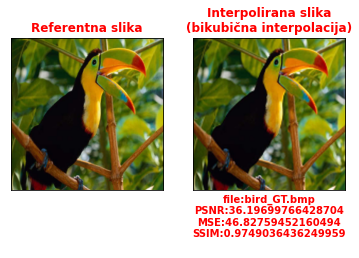

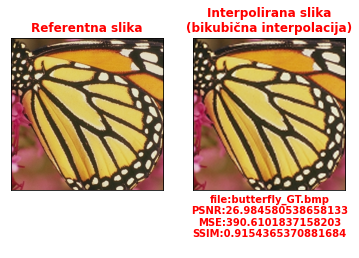

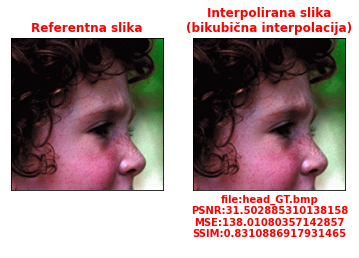

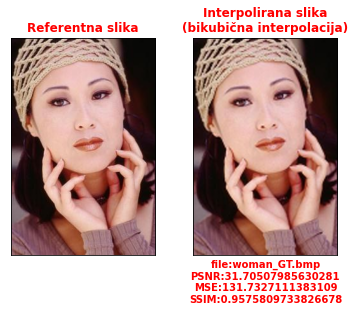

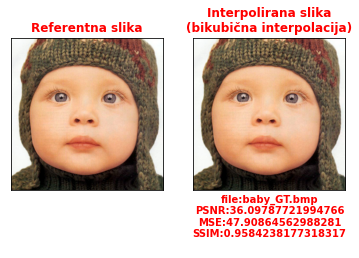

In [ ]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bikubicna interpolacija)')
for file in os.listdir('drive/MyDrive/slike2/'):
  imageA = cv2.imread('drive/MyDrive/slike2/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bikubična interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})


Poredjenje originalne slike i interpolirane(bilinearna)


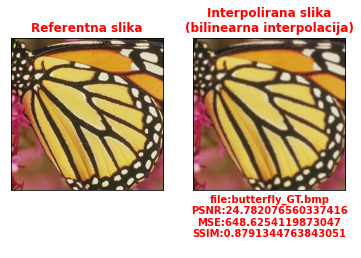

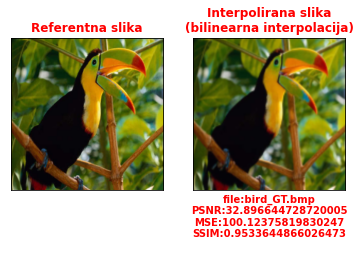

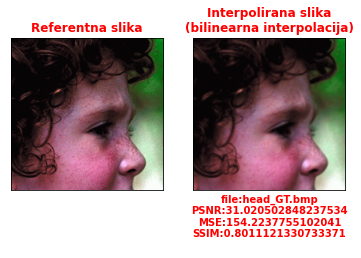

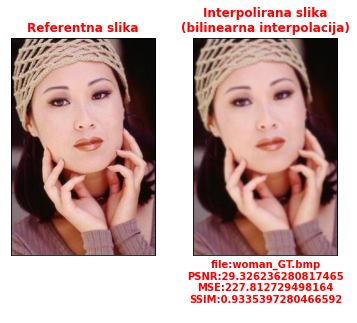

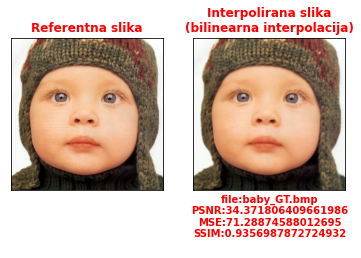

In [ ]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bilinearna)')
for file in os.listdir('drive/MyDrive/slike1/'):
  imageA = cv2.imread('drive/MyDrive/slike1/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bilinearna interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})



Poredjenje originalne slike i slike dobijene nakon primene SRCNN


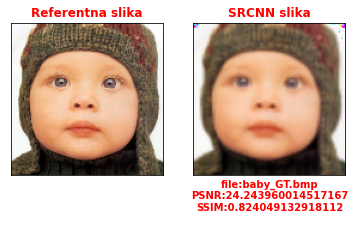

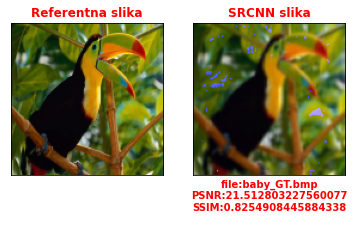

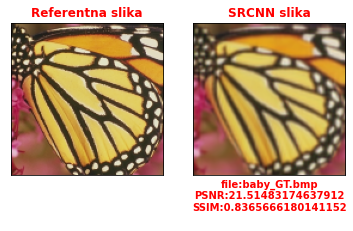

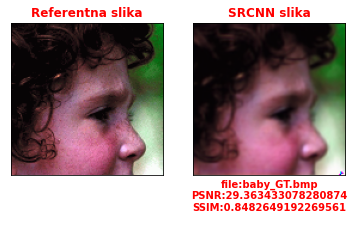

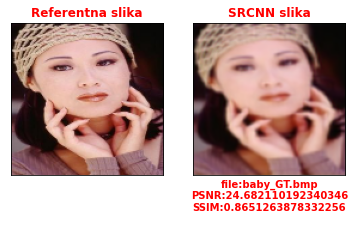

In [ ]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN')
i = 0
for i in range(5):
  imageA = (result[i]*255).astype(np.uint8)
  imageB = (testImage[i]*255).astype(np.uint8)
  
  i+=1
  Psnr = psnr1(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nSSIM:{}\n'.format(file,Psnr,SSIM),fontdict={'fontweight': 'bold','color':'red'})
